In [25]:
import torch
import numpy as np
import torchvision.models as models
import Custom as CustomDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

"""
Do not run this code block without cuda()

Load in vgg16, 
"""
vgg16 = models.vgg16(pretrained=True).cuda()
#vgg16 = models.vgg16(pretrained=True)
customDataloader = CustomDataset.main() #for dataloader

for param in vgg16.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
vgg16_fcn = vgg16.features 
vgg16_fcn.cuda()




~~~| Custom.py Execution |~~~
Loaded dataset
~~~| Custom.py Complete |~~~



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [26]:
def getDataPoint(element, index):
    scores = []
    for frame in range(len(element['video'][index])):
        video = element['video'][index]
        #plt.imshow(video[frame].numpy())
        #plt.show(block=False)
        
        #print(data['video'][seg][frame].shape)
        #print(element['scores'][frame][index])
        scores.append(int(element['scores'][frame][index]))
    points = np.zeros((7,3), dtype=int)
    frames = np.add(*np.indices((7, 3)))
    if (1 in scores):
        boundary = scores.index(1)
        for i in range(7):
            for j in range(3):
                frames[i][j] = i + j
                if (i + j == boundary):
                    points[i][j] = 1
    return points.tolist(), frames.tolist(), video, index

def parseVideoMatrix(vid, positions):
    vid = vid.numpy()
    newData = np.zeros((7, 3, 3, 224,224))
    count = 0
    for i in positions:
        frames = np.zeros((3, 3, 224, 224))
        for j in range(len(i)):
            #Models expect 3xHxW
            #Current format before swaps, WxHx3
            frames[j,...] = np.swapaxes(vid[i[j]], 0, 2)
        newData[count,...] = frames
        count += 1
    return newData
    
def parseViewVids(vid, positions):
    vid = vid.numpy()
    newData = np.zeros((7, 3, 224, 224,3))
    count = 0
    for i in positions:
        frames = np.zeros((3, 224, 224, 3))
        for j in range(len(i)):
            #Models expect 3xHxW
            #Current format before swaps, WxHx3
            frames[j,...] = vid[i[j]]
        newData[count,...] = frames
        count += 1
    return newData

def viewVideo(vid):
    for i in vid:
        for j in i:
            plt.imshow(j)
            plt.show(block=False)
            

"""
Reading in data to get single batch for training
"""
batchData = []
for batch_i, data in enumerate(customDataloader): 
    print(batch_i)
    for i in range(len(data['video'])):
        scoreList, frameNums, vidData, index = getDataPoint(data, i)
        dataItem = parseVideoMatrix(vidData, frameNums)
        batchData.append([scoreList, dataItem])
        print(dataItem.shape)
        print(scoreList)
    if batch_i == 2:
        break
        

0
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
1
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0]]
2
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(7, 3, 3, 224, 224)
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1]]
(7, 3, 3, 224,

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


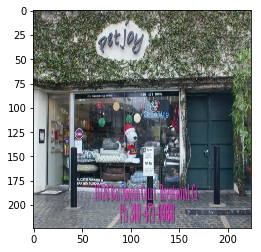

(224, 224, 3)


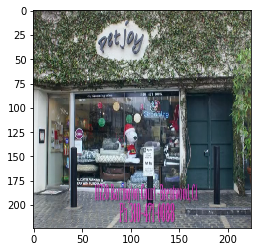

(224, 224, 3)


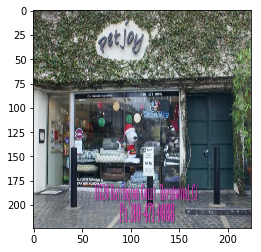

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


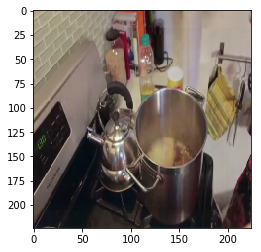

(224, 224, 3)


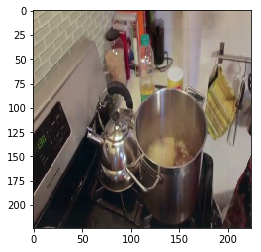

(224, 224, 3)


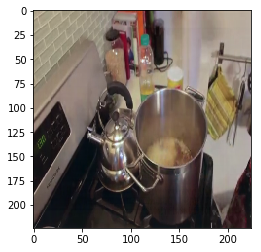

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]
(224, 224, 3)


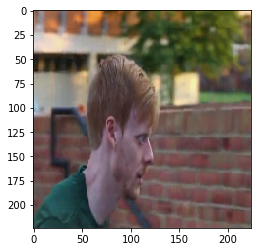

(224, 224, 3)


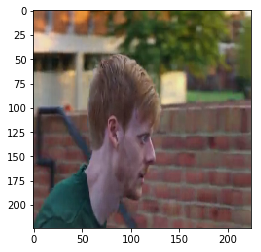

(224, 224, 3)


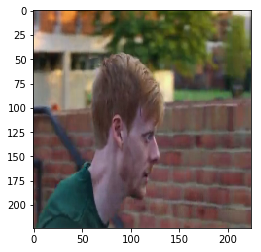

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


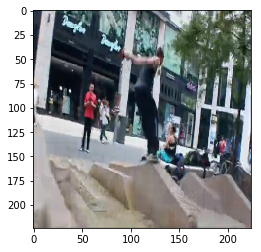

(224, 224, 3)


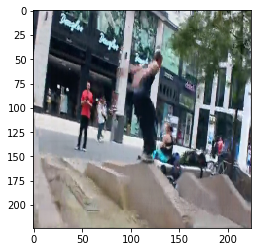

(224, 224, 3)


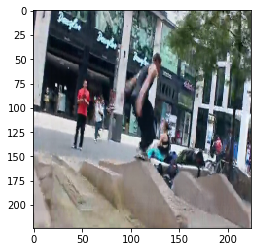

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0]]
(224, 224, 3)


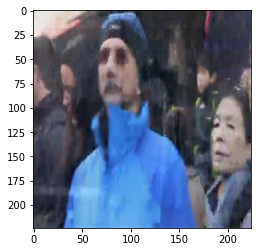

(224, 224, 3)


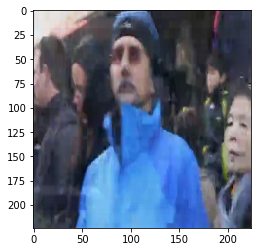

(224, 224, 3)


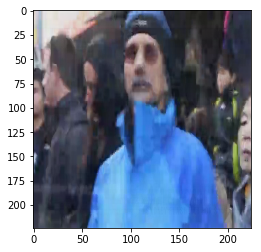

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


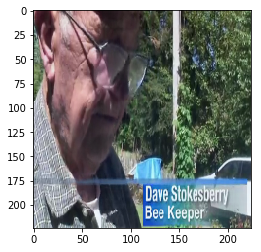

(224, 224, 3)


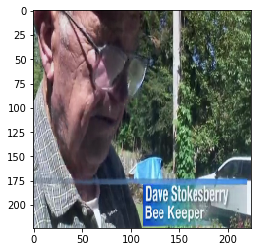

(224, 224, 3)


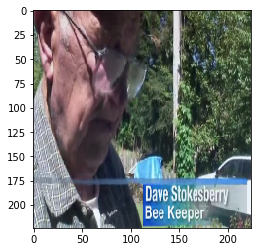

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]
(224, 224, 3)


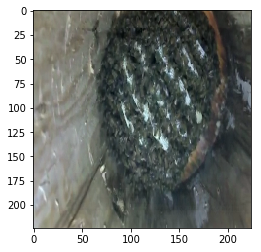

(224, 224, 3)


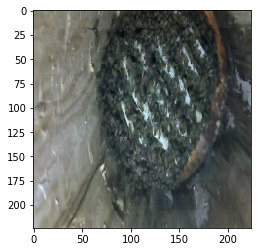

(224, 224, 3)


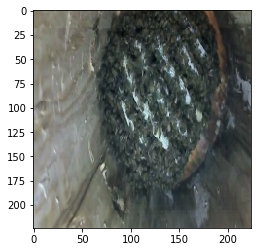

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0]]
(224, 224, 3)


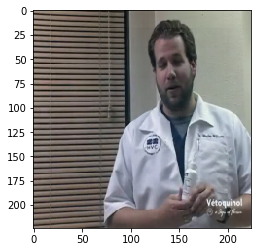

(224, 224, 3)


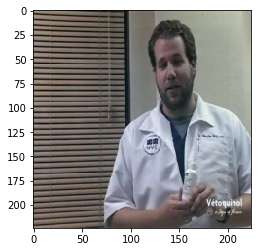

(224, 224, 3)


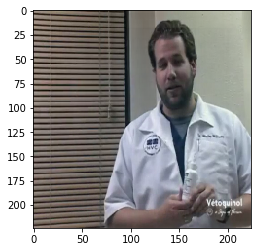

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


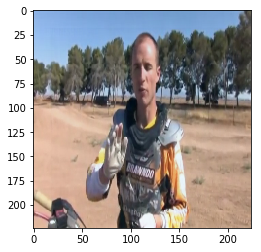

(224, 224, 3)


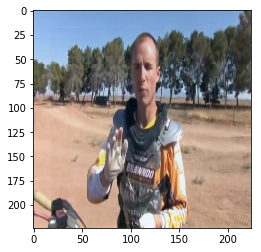

(224, 224, 3)


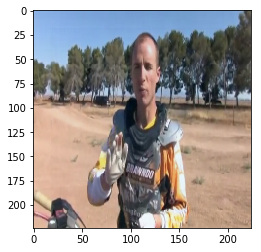

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1]]
(224, 224, 3)


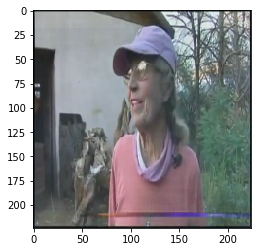

(224, 224, 3)


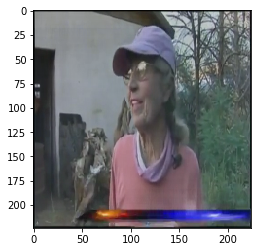

(224, 224, 3)


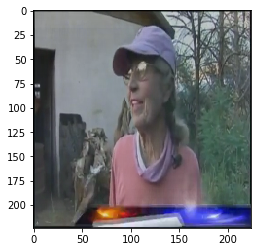

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


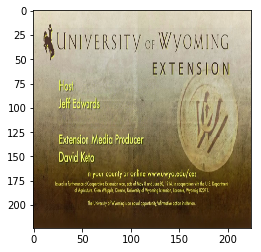

(224, 224, 3)


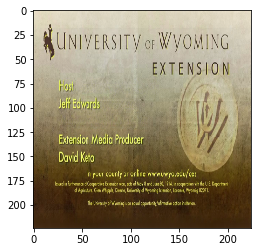

(224, 224, 3)


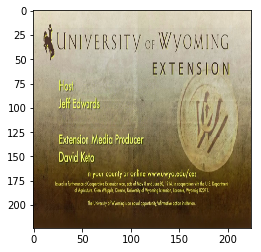

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
(224, 224, 3)


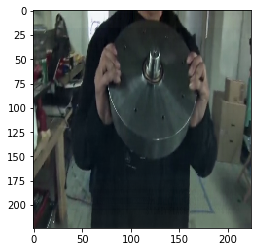

(224, 224, 3)


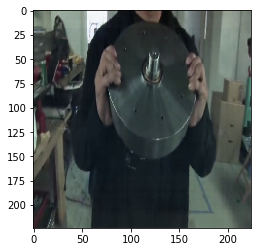

(224, 224, 3)


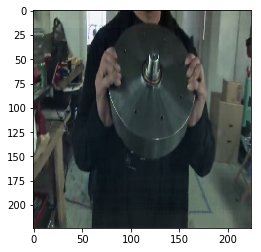

In [27]:
"""               
model = MyModel(512*7*7, 256)
print(batchOne.shape)
print(batchTwo.shape)
print(batchOne[:,0,:,:,:].shape)

out = np.squeeze(model(512*7*7, batchOne))
print(out.shape)
print(out)
out2 = np.squeeze(model(512*7*7, batchTwo))
print(out2.shape)
print(out2)
"""
#Data Validation - Show first sequence of each data item
for i in range(len(batchData)):
    #Print ScoreList of Data to be shown
    print(batchData[i][0])
    for j in range(len(batchData[i][1])):
        frames = np.swapaxes(batchData[i][1][j], 1, 3)
        for f in frames:
            print(f.shape)
            plt.imshow(f)
            plt.show(block=False)
        break


In [28]:
"""
USING SIGMOID
"""

import torch.nn as nn
from torch.nn.parameter import Parameter
class MyModel(nn.Module):
    def __init__(self, inputDim, outputDim):
        super(MyModel, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        #vgg16 = models.vgg16(pretrained=True).cuda()
        for param in vgg16.parameters():
            param.requires_grad = False
            # Replace the last fully-connected layer
            # Parameters of newly constructed modules have requires_grad=True by default
        self.vgg16_fcn = vgg16.features
        #self.vgg16_fcn.cuda()
        self.lstm = torch.nn.LSTM(inputDim, outputDim, 1, True, True, 0.5);
        self.fc = nn.Linear(outputDim, 1)
        self.flatten_parameters()
        self.sigmoid = nn.Sigmoid()
        self.inputDim = inputDim
    
    def flatten_parameters(self):
        self.lstm.flatten_parameters()
        
    def forward(self, x):
        newBatch = []
        for t in range(len(x[1])):
            newBatch.append(self.vgg16_fcn(x[:,t,:,:,:].float()))
        grad = False
        
        #4 x 3 x (512 x 7 x 7)
        vggOut = torch.stack(newBatch, 1).detach_()
        #print(vggOut.shape)
        
        #4 x 3 x 25088
        test = vggOut.view((4,3,-1))
        #print(test.shape)
        
        #Output from LSTM 4 x 3 x 256
        lstmOut, _ = self.lstm(test)
        #print(lstmOut.shape)
        
        #Output from Fully Connected Layer 4 x 3 x 1
        #fcOut = self.fc(lstmOut)
        #print(fcOut)
        #return fcOut
        
        sigOut = self.sigmoid(self.fc(lstmOut))
        #print(sigOut)
        return sigOut

In [ ]:
"""
Not Using Cuda
Extremely Slow
"""
model = MyModel(512*7*7, 256)
batchOne = dataItem[0:4]
batchTwo = dataItem[3:]
#print(batchOne.shape)
#print(batchTwo.shape)
data = [batchOne, batchTwo]
#Ground Truth
scoreOnes = np.squeeze(scoreList[0:4])
scoreTwo = np.squeeze(scoreList[3:])
GT = [scoreOnes, scoreTwo]

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    for i in range(len(data)):
        x = Variable(torch.tensor(data[i], dtype=torch.float32))
        y = Variable(torch.tensor(GT[i], dtype=torch.float32))
        optimizer.zero_grad()
        out = model(x)
        out = out.squeeze()
        error = nn.functional.binary_cross_entropy(input=out, target=y, reduce=True)
        error.backward()        
        optimizer.step()
    #if epoch % 5 == 0:
        print('epoch %d:' % epoch, error.item())
"""
Not Using Cuda
Extremely Slow
"""

In [37]:
"""
Using Cuda

"""

model = MyModel(512*7*7, 256).cuda()
#batchOne = dataItem[0:4]
#batchTwo = dataItem[3:]
#print(batchOne.shape)
#print(batchTwo.shape)
#data = [batchOne, batchTwo]
#Ground Truth
#scoreOnes = np.squeeze(scoreList[0:4])
#scoreTwo = np.squeeze(scoreList[3:])
#GT = [scoreOnes, scoreTwo]

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 101
for epoch in range(num_epochs):
    for i in range(len(batchData)):
        #Within batchData - batchData[0]: score, batchData[1]:video data
        data = [batchData[i][1][0:4], batchData[i][1][3:]]
        #Ground Truth
        GT = [np.squeeze(batchData[i][0][0:4]), np.squeeze(batchData[i][0][3:])]
        for j in range(2):
            x = Variable(torch.tensor(data[j], dtype=torch.float32)).cuda()
            y = Variable(torch.tensor(GT[j], dtype=torch.float32)).cuda()
            optimizer.zero_grad()
            out = model(x)
            out = out.squeeze()
            error = nn.functional.binary_cross_entropy(input=out, target=y, reduce=True).cuda()
            error.backward()        
            optimizer.step() 
            if (epoch) % 20 == 0:
                print('item: ' + str(i+1) + ' epoch:' + str(epoch) + '\n\tbatch: ' + str(j) + ', error: ' + str(error.item()))

item: 1 epoch:0
	batch: 0, error: 0.6411216259002686
item: 1 epoch:0
	batch: 1, error: 0.371522456407547
item: 2 epoch:0
	batch: 0, error: 0.5897281765937805
item: 2 epoch:0
	batch: 1, error: 0.34323057532310486
item: 3 epoch:0
	batch: 0, error: 0.5986451506614685
item: 3 epoch:0
	batch: 1, error: 0.6177887320518494
item: 4 epoch:0
	batch: 0, error: 0.6001524925231934
item: 4 epoch:0
	batch: 1, error: 0.42257678508758545
item: 5 epoch:0
	batch: 0, error: 0.646174967288971
item: 5 epoch:0
	batch: 1, error: 0.6752721667289734
item: 6 epoch:0
	batch: 0, error: 0.6160426735877991
item: 6 epoch:0
	batch: 1, error: 0.6327351927757263
item: 7 epoch:0
	batch: 0, error: 0.595893383026123
item: 7 epoch:0
	batch: 1, error: 0.5786117911338806
item: 8 epoch:0
	batch: 0, error: 0.6208403706550598
item: 8 epoch:0
	batch: 1, error: 0.565699577331543
item: 9 epoch:0
	batch: 0, error: 0.5800976157188416
item: 9 epoch:0
	batch: 1, error: 0.34943708777427673
item: 10 epoch:0
	batch: 0, error: 0.5246416926